In [52]:
import requests
import json
import time
import pandas as pd
from utils import extract_individual_player_features
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

### Get market players 

I know that endpoint

In [ ]:
AUTH_TOKEN = '5e65_20f468a19ad19ef73979642df99d6603'
USER_ID = '56c6b62085617f9b1dc7d061'
CHAMPIONSHIP_ID = '5f7b19924dcd043e8a092dd4'
USERTEAM_ID = '5f7b33ea6f9120324dedcb15'

headers = {
    'Authorization': f'Bearer {AUTH_TOKEN}',
    'x-futmondo-token': AUTH_TOKEN,
    'x-futmondo-userid': USER_ID}

In [39]:
# STEP 1: Get all player IDs from market
response = requests.post(
    'https://api.futmondo.com/1/market/players',
    headers=headers,
    json={'query': {
        'championshipId': CHAMPIONSHIP_ID,
        'userteamId': USERTEAM_ID}})

market_data = response.json()
all_players = market_data['answer']

# STEP 2: Get detailed data for each player
detailed_players = []

for i, player in enumerate(all_players):
    player_id = player['id']
    player_name = player['name']
    
    print(f"{i+1}/{len(all_players)}: {player_name}...")
    
    response = requests.post(
        'https://api.futmondo.com/1/player/summary',
        headers=headers,
        json={'query': {
            'playerId': player_id,
            'championshipId': CHAMPIONSHIP_ID
        }}
    )
    
    if response.status_code == 200:
        detailed_players.append(response.json())
    
    time.sleep(0.5)  # Don't spam the API

1/20: Takuma Asano...
2/20: Budimir...
3/20: Rashford...
4/20: Vesga...
5/20: Dela...
6/20: Iker Losada...
7/20: Germán Valera...
8/20: Gerard Moreno...
9/20: Carles Aleñá...
10/20: Koundé...
11/20: Güler...
12/20: Ter Stegen...
13/20: De Jong...
14/20: Raba...
15/20: Juanlu...
16/20: Isaac Romero...
17/20: Manu Fernández...
18/20: N. González...
19/20: Antony...
20/20: Laporte...


In [48]:
# Save everything
# with open('all_detailed_players_2.json', 'w', encoding='utf-8') as f:
#     json.dump(detailed_players, f, indent=2, ensure_ascii=False)

### Get all players features

In [ ]:
# Usage
with open('all_detailed_players_2.json', 'r') as f:
    json_array = json.load(f)

rows = [extract_individual_player_features(item) for item in json_array]
df_features = pd.DataFrame(rows)
# df_features.to_csv('players_dataset.csv', index=False)

In [32]:
df_features.head(2)

,player_id,name,team,role,total_points,matches_played,average,home_average,away_average,last_5_average,...,is_home_next,opponent_next,team_win_prob,draw_prob,opponent_win_prob,match_minus_1,match_minus_2,match_minus_3,match_minus_4,match_minus_5
0,55916197c498293442727262,Unai Simón,Athletic de Bilbao,portero,57,14,4.071429,4.0,4.142857,2.4,...,True,Real Madrid,21.941294,23.508529,54.550178,8,-1,4,-2,3
1,577fc05cd0b969de4e1a7096,Chimy Ávila,Betis,delantero,4,5,0.800000,0.0,1.000000,0.0,...,True,Barcelona,23.450716,22.133260,54.416025,0,0,0,0,0


### Training data

In [50]:
# List to store all training samples
all_samples = []

# Loop through all players
for player_data in detailed_players:
    answer = player_data['answer']
    player_info = answer['data']
    
    historical_matches = answer.get('points', [])
    if len(historical_matches) < 4:
        continue
    
    # Extract price history for max and min
    prices = [p['price'] for p in answer['prices']]
    max_price = max(prices)
    min_price = min(prices)
    
    # Create sliding windows of 4 matches (3 for features, 1 for target)
    for i in range(len(historical_matches) - 3):
        match_window = historical_matches[i:i+4]
        feature_matches = match_window[:3]
        target_match = match_window[3]
        
        feature_points = [m['points'] for m in feature_matches]
        last_3_average = sum(feature_points) / 3
        
        # Get home/away averages from overall player stats
        home_average = player_info['average']['homeAverage']
        away_average = player_info['average']['awayAverage']
        is_home_target = target_match['isHomeTeam']
        target_points = target_match['points']
        round_number = target_match['round']
        
        # Create sample dictionary
        sample_dict = {
            'player_id': player_info['id'],
            'name': player_info['name'],
            'team': player_info['team'],
            'role': player_info['role'],
            'round': round_number,
            'home_average': home_average,
            'away_average': away_average,
            'overall_average': player_info['average']['average'],
            'last_3_average': last_3_average,
            'current_price': player_info['value'],
            'max_price': max_price,
            'min_price': min_price,
            'is_home_target': is_home_target,
            'match_minus_1': feature_matches[2]['points'],
            'match_minus_2': feature_matches[1]['points'],
            'match_minus_3': feature_matches[0]['points'],
            'target_points': target_points}
        all_samples.append(sample_dict)

df = pd.DataFrame(all_samples)

In [ ]:
# df.to_csv('training_data.csv', index=False)
# print("\n✅ Training data saved to 'training_data.csv'")

In [53]:
df.head(2)

,player_id,name,team,role,round,home_average,away_average,overall_average,last_3_average,current_price,max_price,min_price,is_home_target,match_minus_1,match_minus_2,match_minus_3,target_points
0,57791b1d563eecc513bbd95b,Takuma Asano,Mallorca,delantero,4,3.333333,1.5,2.6,2.000000,1000000,1000000,1000000,False,1,3,2,0
1,57791b1d563eecc513bbd95b,Takuma Asano,Mallorca,delantero,5,3.333333,1.5,2.6,1.333333,1000000,1000000,1000000,True,0,1,3,5


### Model Prediction

In [ ]:
# Load training data
df = pd.read_csv('training_data.csv')

📊 Loaded 240 training samples
Players: 23

📈 Training samples: 192
🧪 Test samples: 48

🤖 Training Random Forest model...

✅ MODEL PERFORMANCE:
Mean Absolute Error: 2.25 points
Root Mean Squared Error: 3.38 points
R² Score: -0.036

📊 FEATURE IMPORTANCE:
            feature  importance
8     match_minus_1    0.185969
3    last_3_average    0.131704
6         min_price    0.112989
9     match_minus_2    0.107248
10    match_minus_3    0.097788
5         max_price    0.079450
4     current_price    0.079019
0      home_average    0.069726
2   overall_average    0.058344
1      away_average    0.054073
7    is_home_target    0.023690

🔮 Making predictions for 23 players...

🏆 TOP 15 PREDICTED PERFORMERS:
          name               team           role  is_home_next  last_5_average  team_win_prob  predicted_points_ml
 Carlos Romero           Espanyol        defensa          True             6.0      40.866402                 7.02
        Ounahi             Girona centrocampista          Tru

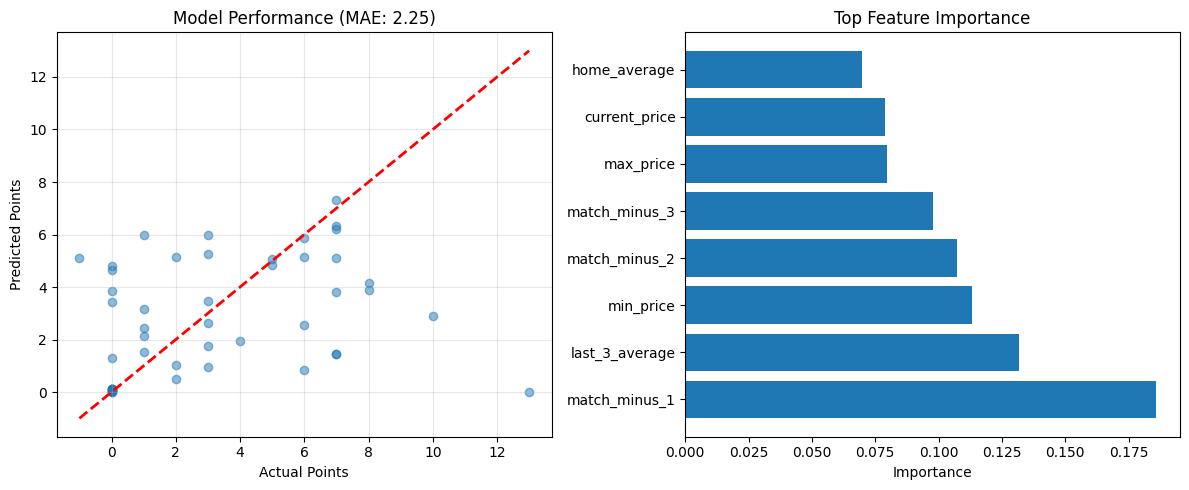

In [ ]:
# Features for the model
feature_columns = [
    'home_average', 'away_average', 'overall_average',
    'last_3_average', 'current_price', 'max_price', 'min_price',
    'is_home_target', 'match_minus_1', 'match_minus_2', 'match_minus_3']

df['is_home_target'] = df['is_home_target'].astype(int)

# Prepare X (features) and y (target)
X = df[feature_columns]
y = df['target_points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== TRAIN MODEL =====
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42)
model.fit(X_train, y_train)

# ===== EVALUATE MODEL =====
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ MODEL PERFORMANCE:")
print(f"Mean Absolute Error: {mae:.2f} points")
print(f"Root Mean Squared Error: {rmse:.2f} points")
print(f"R² Score: {r2:.3f}")

# ===== FEATURE IMPORTANCE =====
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 FEATURE IMPORTANCE:")
print(feature_importance)

# ===== PREDICT NEXT MATCHES =====
df_current = pd.read_csv('player_features.csv')

# Prepare features for prediction (using last 5 matches as last 3)
predict_features = pd.DataFrame({
    'home_average': df_current['home_average'],
    'away_average': df_current['away_average'],
    'overall_average': df_current['average'],
    'last_3_average': df_current['last_5_average'],
    'current_price': df_current['current_price'],
    'max_price': df_current['max_price'],
    'min_price': df_current['min_price'],
    'is_home_target': df_current['is_home_next'].astype(int),
    'match_minus_1': df_current['match_minus_1'],
    'match_minus_2': df_current['match_minus_2'],
    'match_minus_3': df_current['match_minus_3']})

df_current['predicted_points_ml'] = model.predict(predict_features)
results = df_current[['name', 'team', 'role', 'is_home_next', 
                       'last_5_average', 'team_win_prob', 'predicted_points_ml']].copy()
results['predicted_points_ml'] = results['predicted_points_ml'].round(2)

In [ ]:
# # Save predictions
# df_current.to_csv('ml_predictions.csv', index=False)
# print("\n✅ Predictions saved to 'ml_predictions.csv'")

NameError: name 'y_test' is not defined

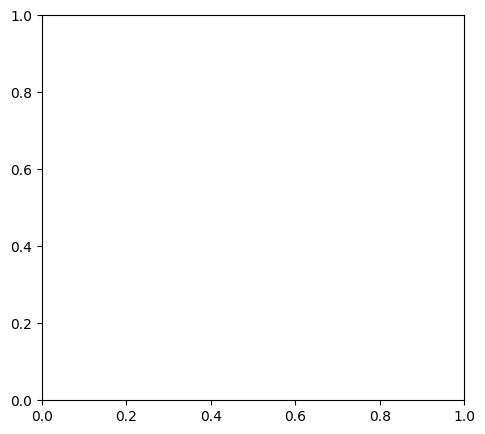

In [55]:
# ===== VISUALIZATION =====
plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title(f'Model Performance (MAE: {mae:.2f})')
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
top_features = feature_importance.head(8)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top Feature Importance')
plt.tight_layout()
print("📊 Evaluation plot saved to 'model_evaluation.png'")
plt.show()